In [265]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import numpy as np
from scipy.stats import kruskal
from scipy.stats import shapiro
from numpy.random import choice
from scipy.stats import chi2_contingency

In [266]:
alpha = 0.05 # уровень значимости для статистических тестов
target_factor = 'score' # целевой фактор
# исходная метаинформация (допустимые знаечния, типы колонок)
parent_education_levels = [0, 1, 2, 3, 4]
parent_jobs = ['teacher', 'health', 'services', 'at_home', 'other']
yes_no_options = ['yes', 'no']
acceptable_ranges = {
    'sex':['F', 'M'],
    'age':list(range(15,23)),
    'address':['U', 'R'],
    'famsize':['LE3', 'GT3'],
    'Pstatus':['T', 'A'],
    'Medu':parent_education_levels,
    'Fedu':parent_education_levels,
    'Mjob':parent_jobs,
    'Fjob':parent_jobs,
    'reason':['home', 'reputation', 'course', 'other'],
    'guardian':['mother', 'father', 'other'],
    'traveltime':[1, 2, 3, 4],
    'studytime':[1, 2, 3, 4],
    'failures':[0, 1, 2, 3],
    'schoolsup':yes_no_options,
    'famsup':yes_no_options,
    'paid':yes_no_options,
    'activities':yes_no_options,
    'nursery':yes_no_options,
    'higher':yes_no_options,
    'internet':yes_no_options,
    'romantic':yes_no_options, 
    'famrel':list(range(1,6)),
    'freetime':list(range(1,6)),
    'goout':list(range(1,6)),
    'health':list(range(1,6)),
    target_factor:list(range(0,101))
}
continous_factors = ['absences']

### Читаем данные, определяем numeric / binary колонки, колонки с неполными данными

In [267]:
data = pd.read_csv('stud_math.csv')
total_rows = data.shape[0]
uncomplete_factors = list(filter(lambda d: data[d].count() < total_rows, data.columns))
unique_values_per_column = {}
for c in data.columns:
    uv = data[c].nunique()
    unique_values_per_column[c] = (uv - 1) if c in uncomplete_factors else uv
binarry_columns = list(filter(lambda c: unique_values_per_column[c] < 3, unique_values_per_column))
is_numeric = data.dtypes.apply(lambda c: c.kind in 'iuf').reset_index()
is_numeric.columns = ['col_name', 'is_numeric']
numeric_columns = is_numeric[is_numeric.is_numeric].col_name.to_numpy()
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

### Фильтруем данные, используя знания о допустимых значениях факторов

In [268]:
def filter_outliers(d, acceptable_values):
    if (d in acceptable_values):
        return d
    else:
        return None
categorial_factors = list(filter(lambda c: (c != target_factor) & (not c in continous_factors), data.columns))
for k in acceptable_ranges.keys():
    data[k] = data[k].apply(lambda d: filter_outliers(d, acceptable_ranges[k]))

### Исследуем распределения значений в колонках

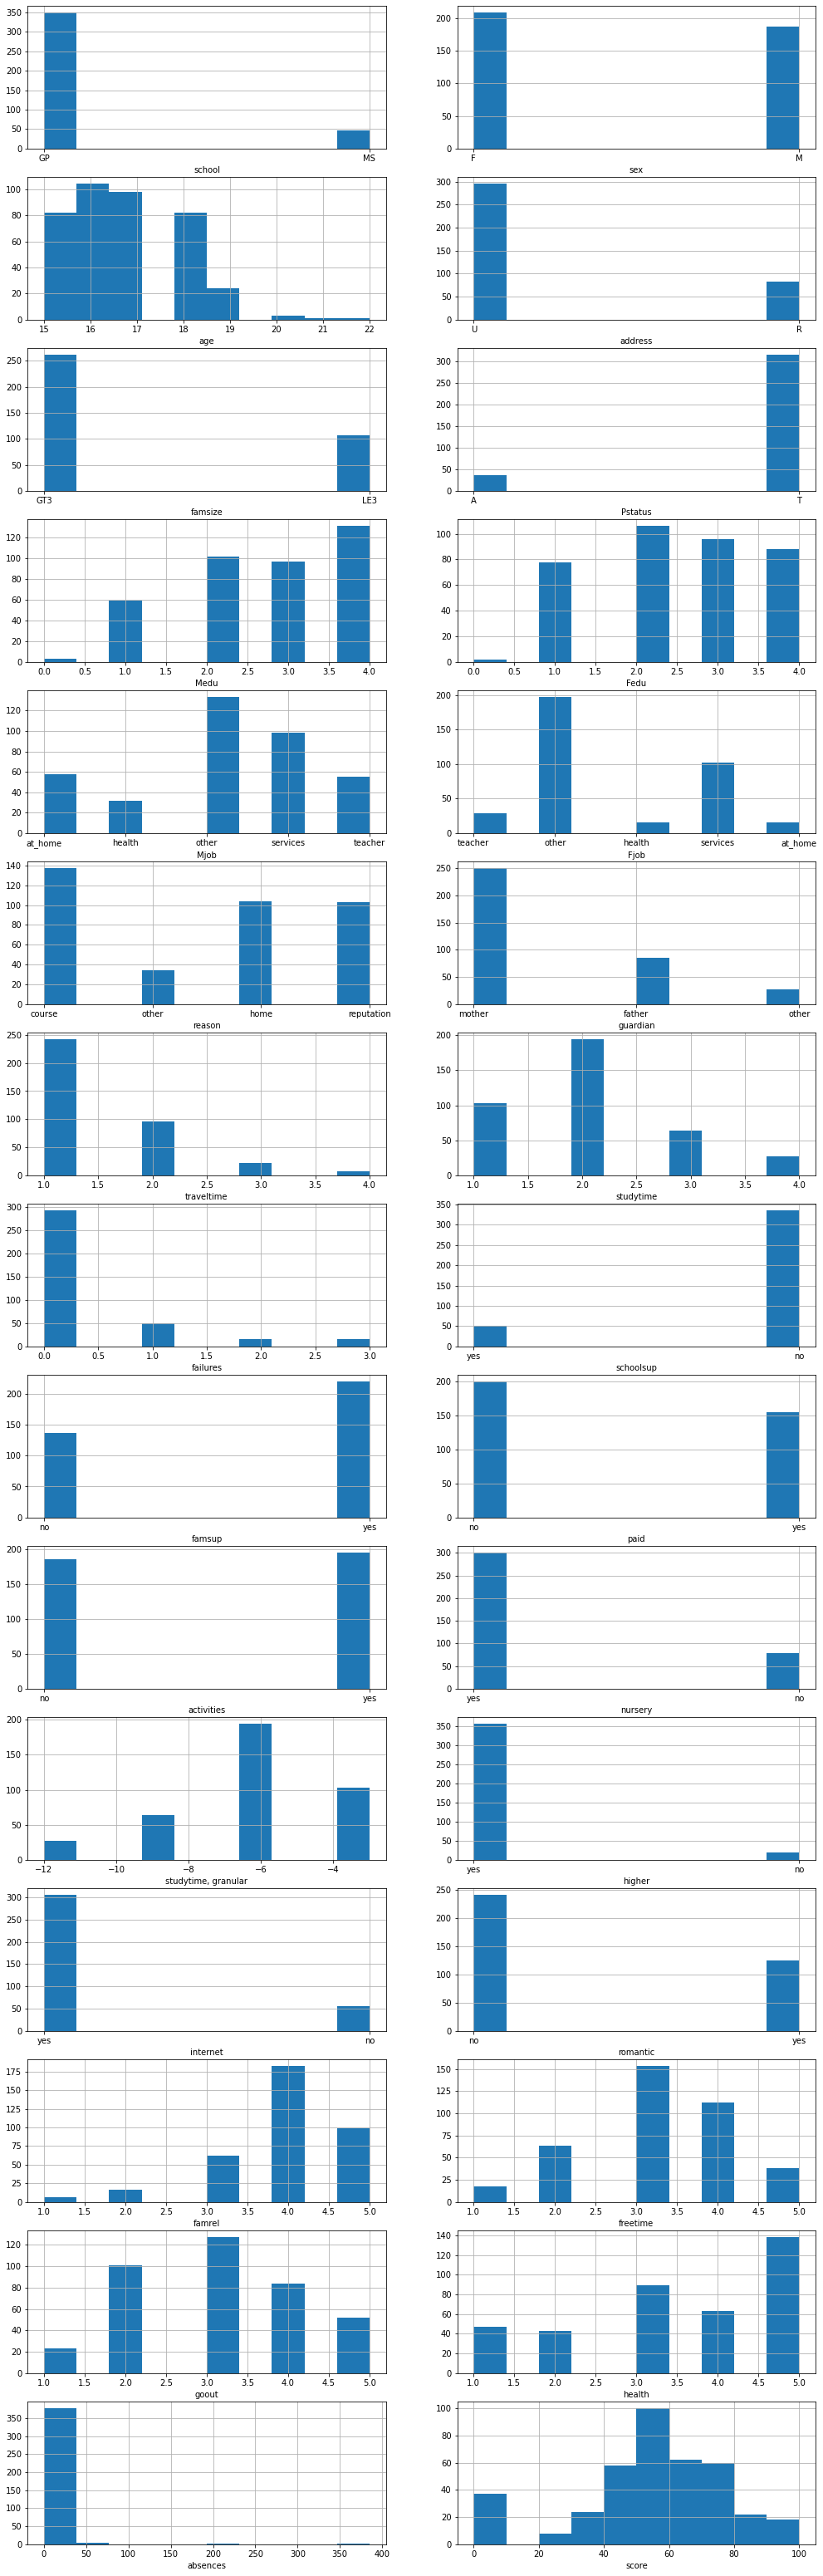

In [269]:
rows = round(len(data.columns) / 2) + 1
ncols = 2
fig = plt.figure(figsize=(17, 60))

for i, c in enumerate(data.columns):
    ax = fig.add_subplot(rows, ncols, i + 1)
    series = data[c]
    series[series.notnull()].hist()
    ax.set_xlabel(c)

### Исследуем зависимость колонок `studytime` и `studytime, granular`

In [270]:
not_null_data = data[data['studytime'].notnull() & data['studytime, granular'].notnull()].reset_index()
not_null_data['study_columns_diff'] = not_null_data['studytime'] == (not_null_data['studytime, granular'] / -3.0)
matched_values = not_null_data['study_columns_diff'].value_counts()[True]
if matched_values == not_null_data.shape[0]:
    print("'studytime, granular' is a 'studytime' * (-3)")
else:
    print("'studytime, granular' is a misterious factor")

'studytime, granular' is a 'studytime' * (-3)


### Исследуем нормальность `score`

overall scores doesn't look like Gaussian 0.9293003678321838 1.3257185063272892e-12
hi scores doesn't look like Gaussian 0.9293003678321838 0.0001710216311039403


<AxesSubplot:>

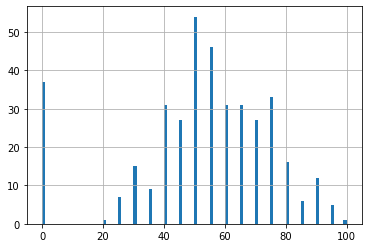

In [271]:
score, p = shapiro(data[data.score.notnull()].score)
if p > alpha:
    print('overall scores are likely to be Gaussian', score, p)
else:
    print("overall scores doesn't look like Gaussian", score, p)
hi_scores = data[data.score.notnull()].score[data.score >= 20]
_, p = shapiro(hi_scores)
if p > alpha:
    print('hi scores are likely to be Gaussian', score, p)
else:
    print("hi scores doesn't look like Gaussian", score, p)
data[data.score.notnull()].score.hist(bins=100)

### Исследуем распределение знаечний `absences`

<AxesSubplot:>

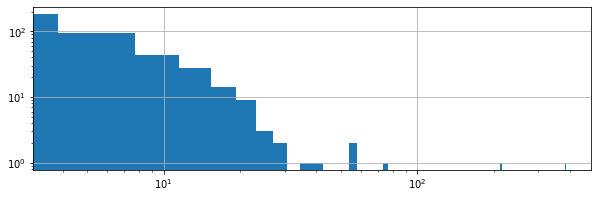

In [272]:
_, ax = plt.subplots(figsize=(10,3))
ax.set_xscale('log')
ax.set_yscale('log')
data.absences.hist(bins=100, ax=ax)

### Наблюдения
- практически все колонки имеют пропуски данных
- большую часть признаков dataset можно отнести к категориальным факторам: `['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime, granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']`
- dataset содержит два дискретных признака: `age` и `absences`
- категориальные признаки распределены между группам весьма неравномерно: например, подавляющее большинство школьников собирается получить высшее образование и имеют доступ в интернет, подавляющее большинство родителей имеют образование
- вариативность значений дискретных факторов весьма мала
- некоторые факторы содержат плохо интерпретируемые значения: например, колонка `failures` принимает значение 0 если кол-во неучебных провалов больше 1 или меньше 3 (включительно), что не позволяет нам отличить крайне успешного школьника (0 провалов) от тотального неудачника (100 провалов)
- в dataset присутствует неизвестный фактор `studytime, granular`: знаечния этой колонки, судя по всему, получены умножением значений колонки `studytime` на `-3`; без дополнительной информации сложно понять назначение колонки, так же, как и смысл арифметического преобразования
- целевой фактор `score` содержит две группы значений: оценки от `20` до `100` (включительно) и `0`; вероятнее всего, такое распределение знаечний связано с характером оценки знаний школьников - в тестах / домашних заданиях невозможно получить оценку менее `20`, оценка `0` означает неявку на экзамен или забытую домашнюю работу
- исследование фактора `score` показало, что значения в данной колонке нельзя отнести к нормальному распределению (ни для всего множества оценок, ни для оценок больше 20)

### Промежуточные выводы
- при заполнении пропущенных данных необходимо учесть вероятности появления значений каждого фактора в отдельности, чтобы учесть структуру групп каждого из них
- для оценки влияния факторов на целевой показатель `score` необходимо использовать непараметрические методы, т.к. значения `score` не распределены нормально
- мы не будем использовать в модели фактор `studytime, granular` из-за трудностей интерпретации, а так же из-за его производного характера - знаечния `studytime, granular` являются представлением значений `studytime`
- дискретный параметр `age` имеет малый диапазон значений, поэтому его стоит рассматривать как категориальный, нежели непрерывный
- большинство значений дискретного параметра `absences` лежат в диапазоне от 0 до 15, при этом значения выше 15 некорректно считать выбросами, т.к. они могут описывать редкую ситуацию (продолжительная болезнь школьника, злостные прогулы) - попытаемся на основе дискретного параметра `absences` создать новый категори альный параемтр `absences_cat`, описывающий кол-во прогулов в категориях "много" / "мало"

In [273]:
uncomplete_factors.remove('studytime, granular')
categorial_factors.remove('studytime, granular')
data.drop(columns=['studytime, granular'], inplace=True)# удаляем производную колонку 'studytime, granular'

### Заполнение пропущенных значений
Пропущенные значения заполним случайными значениями, используя вероятности появления значений факторов и `uniform` генератор случайных чисел. Вероятности появления значений вычислим с помощью действительных частот значений в dataset.
#### Пример
Колонка `Fjob` содержит 36 пустых значений. Возможными знаечниями колонки являются `['teacher', 'other', None, 'health', 'services', 'at_home']`, которые появляются в исходном dataset с такими частотами:
```
other       197
services    102
teacher      29
at_home      16
health       15
```
Из данных частот мы можем получить вероятности появления значений (делим кол-во найденных значений каждого типа на кол-во непустых ячеек в dataset):
```
other -> 0.547
services -> 0.284 
teacher -> 0.081
at_home -> 0.044
health -> 0.041
```
Возможные знаечния и вероятности используем в методе `random.choices` для заполнения пропущенных значений случайными.

In [274]:
random.seed(100500)
for c in uncomplete_factors:
    empty = data.shape[0] - data[c].count()
    not_null_selector = data[c].notnull()
    null_selector = data[c].isnull()
    not_null_series = data[c][not_null_selector]
    total = not_null_series.count()
    value_counts = not_null_series.value_counts()
    options = []
    probabilities = []
    for v in not_null_series.unique():
        options.append(v)
        probabilities.append(value_counts[v] / total)
    generated = pd.Series(random.choices(options, probabilities, k=empty))
    generated.index = data[c][null_selector].index
    data[c].fillna(generated, inplace=True)

### Создаем новые категориальные признаки

In [275]:
absences_cat = 'absences_cat'
lower_absences = data.absences.quantile(0.25)
median_absences = data.absences.quantile(0.5)
top_absences = data.absences.quantile(0.75)

def absences_cat_func(absences):
    if absences <= lower_absences:
        return 'perfect'
    elif absences <= median_absences:
        return 'good'
    elif absences <= top_absences:
        return 'bad'
    else: 
        return 'worst'

data[absences_cat] = data.absences.apply(absences_cat_func)
categorial_factors.append(absences_cat)

### Изучаем влияние категориальных факторов на `score`
Для выявления связи между значениями категориальных факторов с оценками школьников используем ранговый тест `Kruskal-Wallis H Test`. 
Метод выбран по следующим причинам: 
- тест не является параметрическим 
- позволяет сравнивать группы разных порядков
- позволяет сравнивать 2 и более групп

Признаки, имеющие потенциал влияния на оценки по математике будут включены в множество `significant_cat_factors`.

In [276]:
significant_cat_factors = set()
for c in categorial_factors:
    uniques = data[c].unique()
    stds = [data[data[c] == u].score.std() for u in uniques]
    if (max(stds) / min(stds)) >= 5:
        print(c, 'groups std differs too much', stds)
    else:
        scores = [data[data[c] == u].score.to_numpy() for u in uniques]
        _, p = kruskal(*scores)
        if p < alpha:
            significant_cat_factors.add(c)
            print("{} might affect score value! Kruskal-Wallis H Test p-value is {}".format(c, p))
significant_cat_factors

age might affect score value! Kruskal-Wallis H Test p-value is 0.044696733871513024
address might affect score value! Kruskal-Wallis H Test p-value is 0.010149691687973354
Medu might affect score value! Kruskal-Wallis H Test p-value is 0.00025452940627538907
Mjob might affect score value! Kruskal-Wallis H Test p-value is 0.008210338271133636
studytime might affect score value! Kruskal-Wallis H Test p-value is 0.04782750534425132
failures might affect score value! Kruskal-Wallis H Test p-value is 5.721231949831165e-08
schoolsup might affect score value! Kruskal-Wallis H Test p-value is 0.004563634198170777
higher might affect score value! Kruskal-Wallis H Test p-value is 0.0008321559024891276
goout might affect score value! Kruskal-Wallis H Test p-value is 0.016833871209316554
absences_cat might affect score value! Kruskal-Wallis H Test p-value is 0.018764261036829828


{'Medu',
 'Mjob',
 'absences_cat',
 'address',
 'age',
 'failures',
 'goout',
 'higher',
 'schoolsup',
 'studytime'}

### Рассматриваем непрерывные параметры
Дадим оценку связи непрерывных параметров со `score` с помощью корреляционного теста. Будем использовать `Spearman correlation test`, т.к. он оценивает монотонные зависимости параметров.

In [277]:
def describe_spearman(score):
    abs_score = round(abs(score) * 10)
    if abs_score < 2:
        return 'no correlation'
    elif abs_score < 3:
        return 'weak relationship'
    elif abs_score < 4:
        return 'moderate relationship'
    elif abs_score < 6:
        return 'strong relationship'
    else:
        return 'very strong relationship'


for c in continous_factors:
    result = data[[c, 'score']].corr(method='spearman')
    score = result[c]['score']
    print("{} has {} with score({})".format(c, describe_spearman(score), score))

absences has no correlation with score(0.02523519729766743)


Полученное p-value говорит о том, что между абсолютными знаечниеми провусков и полученных оценок на экзамене нет прямой связи.

### Оценка перекрестного влияния факторов
Помимо прямого флияния признаков на целевой показатель `score`, факторы могут иметь опосредованное влияние. Например, мы выяснили, что желание школьников продолжить образование в ВУЗе влияет на их оценки. Однако, значения фактора `higher` могут зависеть от других факторов, например от образования родителей или чего то другого. Т.о. образование родителей может не иметь прямого влияния на `score`, но иметь опосредованное влияние через признак `higher`.

Для выявления связанности категориальных факторов воспользуемся тестом `Pearson’s Chi-Squared Test`.

In [278]:
factors_to_check = sorted(categorial_factors)
relations = {}
fs = set()
for i, factor in enumerate(factors_to_check[0:-1]):
    if not factor in significant_cat_factors:
        for significant in factors_to_check[i+1:]:
            if factor != significant:
                row_values = data[factor].unique()
                col_values = data[significant].unique
                selection = pd.DataFrame(data[[factor, significant]])
                selection['counter'] = 1
                table = selection.groupby([factor, significant]).sum()\
                    .pivot_table(index=factor, columns=significant, values='counter')\
                    .fillna(0).to_numpy()
                _, p, _, _ = chi2_contingency(table)
                if p <= alpha:
                    fs.add(significant)
                    fs.add(factor)                    
                    affected = relations.get(significant, [])
                    affected.append(factor)
                    relations[significant] = affected

In [279]:
significance_levels = {}
def collect_relations(factor, collected, level):
    factor_level = significance_levels.get(level, set())
    factor_level.add(factor)
    significance_levels[level] = factor_level
    result = factor
    if factor in collected:
        return result
    if not factor in relations:
        return result
    items = relations[factor]
    for i in items:
        collected.add(i)
    for i in items:
        result += "\n{}<- {}".format(' ' * 2 * level, collect_relations(i, collected, level + 1))
    return result
print("Факторы, влияющие на `score`: {}\n".format(significant_cat_factors))
print('Связанность категориальных факторов:')
for f in significant_cat_factors:
    collected_factors = set()
    print(collect_relations(f, collected_factors, 1))

Факторы, влияющие на `score`: {'higher', 'studytime', 'schoolsup', 'failures', 'absences_cat', 'goout', 'age', 'address', 'Mjob', 'Medu'}

Связанность категориальных факторов:
higher
  <- Fedu
  <- activities
studytime
  <- famsize
  <- freetime
  <- health
  <- paid
  <- reason
  <- romantic
  <- sex
schoolsup
  <- Fjob
  <- freetime
  <- school
failures
  <- Fedu
absences_cat
  <- Pstatus
goout
  <- freetime
age
address
Mjob
  <- Fedu
  <- Fjob
Medu
  <- Fedu
  <- Fjob


### Заключение
На оценки школьников по математике влияют: 
- желание получить высшее образование `higher` 
- время на учёбу помимо школы в неделю `studytime`
- наличие дополнительной образовательной поддержки `schoolsup` 
- кол-во неучебных неудач `failures` 
- кол-во пропусков занятий `absences_cat`
- кол-во времени проводимого с друзьями `goout`
- возраст `age`
- место жительства `address`
- род занятий мамы `Mjob`
- образование мамы `Medu`

Опосредованное влияние на оценки могут оказать:
- состояние здоровья `health`
- пол `sex`
- размер семьи `famsize`
- работа отца `Fjob`
- наличие романтических отношений `romantic`
- свободное время после школы `freetime` 
- школа, в которой учится школьник `school`
- образование отца `Fedu`
- дополнительные платные занятия по математике `paid`
- статус совместного проживания родителей `Pstatus`
- дополнительные внеучебные занятия `activities`
- причина выбора школы `reason`

Влияние вторичных факторов на основные признаки:
```
higher
  <- Fedu
  <- activities
studytime
  <- famsize
  <- freetime
  <- health
  <- paid
  <- reason
  <- romantic
  <- sex
schoolsup
  <- Fjob
  <- freetime
  <- school
failures
  <- Fedu
absences_cat
  <- Pstatus
goout
  <- freetime
age
address
Mjob
  <- Fedu
  <- Fjob
Medu
  <- Fedu
  <- Fjob
```